In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from google.colab import drive
drive.mount('/content/drive')
mydir = "/content/drive/MyDrive/DeepLearning project/"

Mounted at /content/drive


## Modello costruito da zero

In [ ]:
data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

def build_model(input_shape=(299, 299, 3)):
    inputs = layers.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Blocchi convoluzionali
    x = layers.Conv2D(32, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected finale
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Modello basato su InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Modello InceptionV3
base_model = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(299, 299, 3)
)

# Congelo quasi tutto, sblocco solo ultimi 25 blocchi (per ora)
fine_tune_at = len(base_model.layers) - 25
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Build model
def build_model_v3():
    inputs = layers.Input(shape=(299, 299, 3))
    x = data_augmentation(inputs)

    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    predictions = layers.Dense(1, activation="sigmoid")(x)
    
    return models.Model(inputs, predictions)

## Modello basato su EfficientNetB3

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

# Modello EfficientNetB3
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(299, 299, 3)
)

# Congelo quasi tutto, sblocco solo ultimi 30 blocchi
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Build model
def build_model_b3():
    inputs = layers.Input(shape=(299, 299, 3))
    x = data_augmentation(inputs)

    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    predictions = layers.Dense(1, activation="sigmoid")(x)
    
    return models.Model(inputs, predictions)

## Compilazione dei modelli

In [ ]:
model = build_model()
#model = build_model_v3()
#model = build_model_b3()

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
loss='binary_crossentropy',
metrics=[
    'accuracy',
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.F1Score(name='f1-score')
  ]
)

## Ricarico i modelli dopo un certo numero di epoch e modifico lo stato degli ultimi layer (solo per i modelli con transfer learning)

In [ ]:
model = tf.keras.models.load_model(mydir+"InceptionV3.keras")

for layer in model.get_layer("inception_v3").layers[-45:]: #poi -65
    layer.trainable = True

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), #poi 1e-5
loss='binary_crossentropy',
metrics=[
    'accuracy',
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.F1Score(name='f1-score')
  ]
)

In [ ]:
model = tf.keras.models.load_model(mydir+"efficientNetB3.keras")

for layer in model.get_layer("efficientnetb3").layers[-60:]: #poi -80
    layer.trainable = True

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), #poi 1e-5
loss='binary_crossentropy',
metrics=[
    'accuracy',
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.F1Score(name='f1-score')
  ]
)

## Caricamento del dataset

In [ ]:
import pandas as pd

train = pd.read_csv(mydir+"final/train.csv")
val = pd.read_csv(mydir+"final/val.csv")
test = pd.read_csv(mydir+"final/test.csv")

image_dir = mydir+"final/"

## Funzione di parsing modificata a seconda del modello

In [ ]:
import numpy as np

def parse_function(image_path, label):
    image = tf.io.read_file(image_path+".png")
    image = tf.image.decode_png(image, channels=3)
    
    # Efficient Net non vuole [0, 255]
    # Inception vuole [-1, 1]

    image = tf.cast(image, tf.float32) / 255.0  # normalizzazione
    #image = (image / 127.5) - 1.0
    
    image.set_shape([299, 299, 3])

    label = tf.cast(label, tf.float32)
    label = tf.expand_dims(label, axis=-1)

    return image, label

In [ ]:
batch = 32

## Train set

In [ ]:
import os
image_dir = mydir+"final/"

# Prepara le liste separate
image_paths = [os.path.join(image_dir, item[0]) for item in train.values]
labels = [item[1] for item in train.values]

print(len(image_paths))

df = tf.data.Dataset.from_tensor_slices((image_paths, labels))
train_set = df.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(buffer_size=100).batch(batch).prefetch(tf.data.AUTOTUNE)

7908


## Validation set

In [ ]:
image_paths = [os.path.join(image_dir, item[0]) for item in val.values]
labels = [item[1] for item in val.values]

print(len(image_paths))

df = tf.data.Dataset.from_tensor_slices((image_paths, labels))
val_set = df.map(parse_function)
val_set = val_set.cache().batch(batch).prefetch(tf.data.AUTOTUNE)

988


## Test set

In [ ]:
image_paths = [os.path.join(image_dir, item[0]) for item in test.values]
labels = [item[1] for item in test.values]

print(len(image_paths))

df = tf.data.Dataset.from_tensor_slices((image_paths, labels))
test_set = df.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.shuffle(buffer_size=100).batch(batch).prefetch(tf.data.AUTOTUNE)

989


## Calcolo i pesi per la weigthed loss

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(0.6135235732009926), 1: np.float64(2.702185792349727)}

## (Opzionale) salvo checkpoint del modello

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath=mydir+"InceptionTemp.keras",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

my_callbacks = [
  tf.keras.callbacks.TensorBoard(log_dir=mydir+"./logs"),
  checkpoint
]

## Training

In [ ]:
history = model.fit(train_set,
                    epochs=10,
                    validation_data = val_set,
                    callbacks = my_callbacks,
                    class_weight=class_weights
                    )

In [ ]:
model.save(mydir+"Inception.keras")

## Evaluation su test set

In [ ]:
model.evaluate(test_set)

## Salvo ogni 10 epoch la history

In [ ]:
import json

with open(mydir+'Z10.json', 'w') as f:
    json.dump(history.history, f)

## Ricarico e unisco le history alla fine di tutto il training per stampare il grafico

In [ ]:
from re import M
import json
import pandas as pd

name = "Z"
name = mydir + name

with open(name + "10.json", "r") as f:
    h10 = json.load(f)
with open(name + "20.json", "r") as f:
    h20 = json.load(f)
with open(name + "25.json", "r") as f:
    h25 = json.load(f)

dfs = [pd.DataFrame(h10), pd.DataFrame(h20), pd.DataFrame(h25)]
df_total = pd.concat(dfs, ignore_index=True)

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(df_total['accuracy'], label='acc')
plt.plot(df_total['auc'], label='AUC')
plt.plot(df_total['recall'], label='recall')
plt.plot(df_total['precision'], label='precision')
plt.plot(df_total['f1-score'], label='f1-score')
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df_total['val_accuracy'], label='val acc')
plt.plot(df_total['val_auc'], label='val AUC')
plt.plot(df_total['val_recall'], label='val recall')
plt.plot(df_total['val_precision'], label='val precision')
plt.plot(df_total['val_f1-score'], label='val f1-score')
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()

## Confusion matrix

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os

test = pd.read_csv(mydir+"final/test.csv")
image_dir = mydir+"final/"

image_paths = [os.path.join(image_dir, item[0]) for item in test.values]
labels = [item[1] for item in test.values]

# Creazione test set
X_test = np.array([parse_function(p).numpy() for p in image_paths])
y_test = np.array(labels)

# Predizioni del modello
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizzazione
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.show()

## Esperimenti e predizioni di esempio

In [ ]:
def print_image(img):
    img = img[0, :, :, :]
    
    # In base al modello che utilizzo
    #img = (img + 1) / 2.0
    #img = img / 255.0

    width, height = img.shape[:2]

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    plt.show()
    return

def parse_function(image_path, label):
    image = tf.io.read_file(image_path+".png")
    image = tf.image.decode_png(image, channels=3)
    
    # Efficient Net non vuole [0, 255]
    # Inception vuole [-1, 1]

    image = tf.cast(image, tf.float32) / 255.0  # normalizzazione
    #image = (image / 127.5) - 1.0
    
    image.set_shape([299, 299, 3])

    label = tf.cast(label, tf.float32)
    label = tf.expand_dims(label, axis=-1)

    return image, label

In [ ]:
import pandas as pd
import os

test = pd.read_csv(mydir+"final/test.csv")
image_dir = mydir+"final/"

image_paths = [os.path.join(image_dir, item[0]) for item in test.values]
labels = [item[1] for item in test.values]

In [ ]:
import random

idx = random.randint(0, 987)
image, true_class = parse_function(image_paths[idx], labels[idx])
image = tf.expand_dims(image, axis=0)

## Predizioni di esempio su test set

In [ ]:
preds = model.predict(image)

# Estrai i risultati
pred_class = preds[0][0]
print(true_class.numpy())
print(pred_class)
print_image(image)

## Dall'immagine selezionata prima randomicamente visualizzo la occlusion map

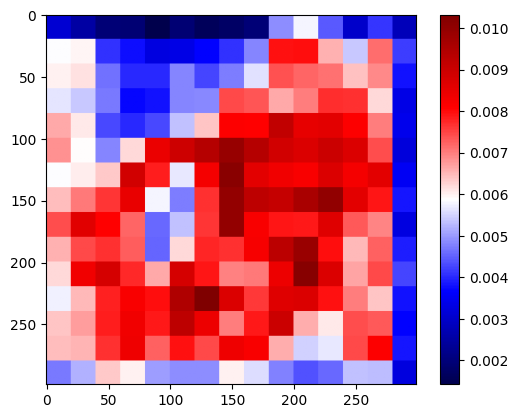

In [ ]:
def occlusion_map(model, img, patch_size=20):
    img = np.array(img)
    h, w, _ = img.shape[1:]
    heatmap = np.zeros((h, w))
    baseline_pred = model.predict(img, verbose=0)[0,0]  # prob classe positiva

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            occluded = img.copy()
            occluded[0, i:i+patch_size, j:j+patch_size, :] = 0  # metti nero
            pred = model.predict(occluded, verbose=0)[0,0]
            heatmap[i:i+patch_size, j:j+patch_size] = baseline_pred - pred

    return heatmap

heatmap = occlusion_map(model, image)
heatmap_abs = np.abs(heatmap)
plt.imshow(heatmap_abs, cmap='seismic')
plt.colorbar()
plt.show()